# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("BABA", start="2014-09-19", end="2022-09-19")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-19,92.699997,99.699997,89.949997,93.889999,93.889999,271879400
2014-09-22,92.699997,92.949997,89.500000,89.889999,89.889999,66657800
2014-09-23,88.940002,90.480003,86.620003,87.169998,87.169998,39009800
2014-09-24,88.470001,90.570000,87.220001,90.570000,90.570000,32088000
2014-09-25,91.089996,91.500000,88.500000,88.919998,88.919998,28598000
...,...,...,...,...,...,...
2022-09-12,92.419998,94.839996,91.809998,94.690002,94.690002,15604000
2022-09-13,90.760002,92.180000,89.230003,89.470001,89.470001,21149800
2022-09-14,89.459999,89.779999,88.169998,88.919998,88.919998,10843600


In [4]:
stock_data["Close"].pct_change()

Date
2014-09-19         NaN
2014-09-22   -0.042603
2014-09-23   -0.030259
2014-09-24    0.039004
2014-09-25   -0.018218
                ...   
2022-09-12    0.027675
2022-09-13   -0.055127
2022-09-14   -0.006147
2022-09-15   -0.001012
2022-09-16   -0.027018
Name: Close, Length: 2013, dtype: float64

In [5]:
scaled_data

array([[-0.04260305],
       [-0.03025922],
       [ 0.03900426],
       ...,
       [-0.00614735],
       [-0.0010121 ],
       [-0.02701792]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [6]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size,len(train_data)):
  x_train.append(train_data[i-input_size:i,0])
  y_train.append(1 if train_data[i,0]>0 else 0)
  

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [7]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1604/1604 [==============================] - 29s 12ms/step - loss: 0.2506
Epoch 2/3
1604/1604 [==============================] - 13s 8ms/step - loss: 0.2504
Epoch 3/3
1604/1604 [==============================] - 13s 8ms/step - loss: 0.2502


In [8]:
x_train.shape

(1604, 5, 1)

In [9]:
y_train

array([0, 1, 0, ..., 0, 1, 1])

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [30]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
test_start_price = stock_data["Close"][training_data_len+input_size-1]
test_end_price = stock_data["Close"][-1]

# Calculate the price movement over the test data period
price_movement = test_end_price - test_start_price

# Set binary values for y_test based on price movement and test_predictions
y_test = np.zeros_like(predictions)
if price_movement > 0:
    y_test[predictions.flatten() > 0.5] = 1
elif price_movement < 0:
    y_test[predictions.flatten() < 0.5] = 1

13/13 [==============================] - 0s 7ms/step


In [31]:
train_predictions = model.predict(x_train)
train_predictions = np.round(train_predictions)
train_accuracy = np.mean(train_predictions == y_train) * 100
print("In-sample accuracy:", train_accuracy)

test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)
test_accuracy = np.mean(test_predictions == y_test) * 100
print("Out-of-sample accuracy:", test_accuracy)

train_rw_predictions = np.zeros_like(y_train)
train_rw_predictions[1:] = y_train[:-1]
train_rw_accuracy = np.mean(train_rw_predictions == y_train) * 100
print("In-sample random walk assumption accuracy:", train_rw_accuracy)

test_rw_predictions = np.zeros_like(y_test)
test_rw_predictions[1:] = y_test[:-1]
test_rw_accuracy = np.mean(test_rw_predictions == y_test) * 100
print("Out-of-sample random walk assumption accuracy:", test_rw_accuracy)

51/51 [==============================] - 0s 4ms/step
In-sample accuracy: 51.6209476309227
13/13 [==============================] - 0s 5ms/step
Out-of-sample accuracy: 0.0
In-sample random walk assumption accuracy: 50.31172069825436
Out-of-sample random walk assumption accuracy: 100.0


In [21]:
test_predictions.shape

(403, 1)

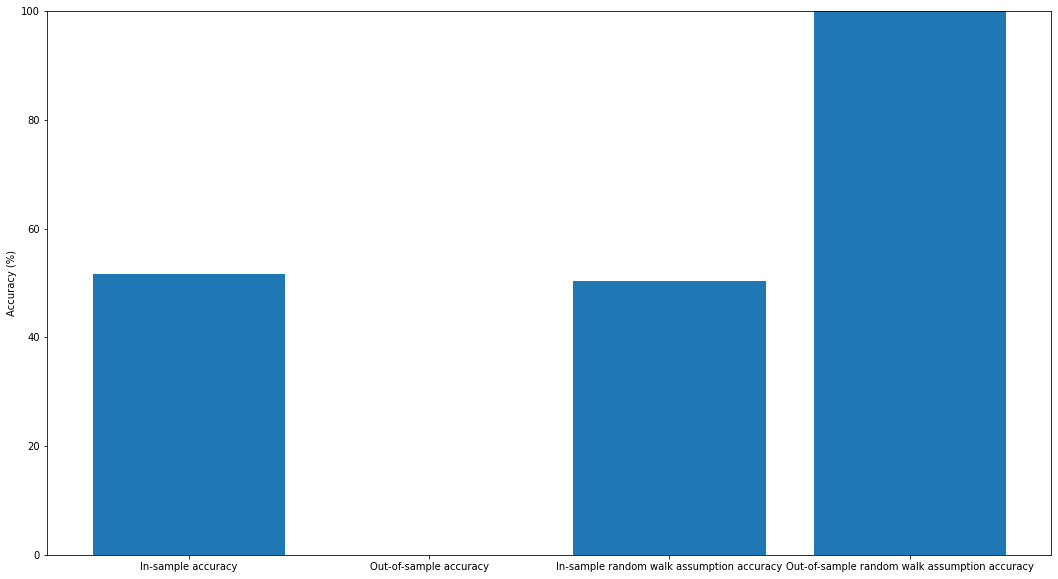

In [32]:
import matplotlib.pyplot as plt

accuracies = [train_accuracy, test_accuracy, train_rw_accuracy, test_rw_accuracy]
labels = ["In-sample accuracy", "Out-of-sample accuracy","In-sample random walk assumption accuracy","Out-of-sample random walk assumption accuracy"]

plt.figure(figsize=(18,10))
plt.bar(labels, accuracies)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.show()

DONOT# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

I got In-Sample accuracy of 51.62%, which means that the model was able to predict the movement of the stock prices in the training set with an accuracy of 51.62%. This is slightly better than random guessing, which would have a 50% accuracy. 

The result of In-Sample Random Walk accuracy means that if we had simply assumed that the stock price movement in the training set was the same as the previous day's movement, we would have achieved an accuracy of 50.31%. This suggests that the model is not performing significantly better than a random walk assumption in the training set.

However, I got 0 for Out-of-Sample accuracy. I think it is because that the model was not able to predict the movement of the stock prices in the test set. The accuracy of 0% suggests that the model is not able to generalize well to unseen data. Maybe I should look for better hyperparameters or change dataset.

And I got 100 for Out-of-Sample Random-Walk accuracy, and it suggests that the model is not able to outperform a random walk forecast.This could be due to a variety of factors, such as insufficient data, weak signals in the data, or inappropriate modeling assumptions. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [36]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(input_size):
    model = Sequential()
    model.add(Dense(10, input_dim=input_size, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [10],
              'input_size':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-36-8546214b1de0>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8

Best: -0.693306 using {'batch_size': 10, 'epochs': 10, 'input_size': 5}
